## Analyse A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to help the company understand if they should implement the new page, or keep the old page.

<a id='probability'></a>
### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

The dataset contains information about the control and treatment group who received the old page and new page, respectively, as well whether they have converted (in buying a product) or not. 

In [3]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# Number of test users and number of unique users in the dataset
df.shape[0], df.user_id.nunique()

(294478, 290584)

The proportion of users converted are almost 12%.

In [5]:
df.converted.mean()

0.11965919355605512

In [7]:
# Additional summary of the DF
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


#### Data Cleaning

The `treatment` and `control` group should receive a `new_page` and `old_page` respectively.

In [8]:
# Computing the number of times the `new_page` and `treatment` don't match.
df[(df["group"] == "treatment") != (df["landing_page"] == "new_page")].count()[0]

3893

In [7]:
df[(df["group"] == "treatment") == (df["landing_page"] == "new_page")].sample(5)

,user_id,timestamp,group,landing_page,converted
118516,756278,2017-01-18 08:28:42.015706,treatment,new_page,0
62668,651780,2017-01-13 12:40:12.023601,control,old_page,0
258129,664970,2017-01-24 02:47:17.402210,treatment,new_page,0
181179,858672,2017-01-10 18:55:11.545287,control,old_page,0
220727,907284,2017-01-17 04:08:54.102824,control,old_page,0


For the rows where `treatment` is not aligned with `new_page` or `control` group is not aligned with `old_page`, it cannot deduced if this row truly received the new or old page.    

For these observations, it is best to remove them as we do not feel confident in the accuracy of the data.

In [8]:
# Drop columns where the group and treatment that do not match
# We will compare the "group: treatment" not equal to "landing_page: new_page", 
# which also eliminates "group: control" not equal to "landing_page: old_page" and drop these columns
df_rm = df[((df["group"] == "treatment") != (df["landing_page"] == "new_page"))]

df2 = df.drop(df_rm.index, axis = 0)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# Double check that all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Now, check for duplicated users and remove duplicated entries

In [14]:
# Returns number of duplicated users
df2.user_id.count() - df2.user_id.nunique()

1

In [16]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [17]:
# Remove duplicated user and check if any remain
df2 = df2.drop(df2[df2.user_id.duplicated()].index, axis = 0)
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


#### Probability summary

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df2.query("group == 'control'").converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df2.query("group == 'treatment'").converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [21]:
df2.query("landing_page == 'new_page'").count()[0] / df2.count()[0]

0.5000619442226688

e. Is there sufficient evidence to say that the new treatment page leads to more conversions?

There is a roughly equal probability that a user receives an old or a new page. This demonstrates that there is not a class imbalance. From the coversion probabilities calculated, the difference in conversions between the control and treatment group is very small. In fact, the probability converted in the control group is higher than treatment. Thus, since the difference is small, there is insufficient evidence to suggest that the `old_page` or the `new_page` is better. We have no means to tell whether the small difference is due to chance or is a real difference without performing hypothesis testing.

<a id='ab_test'></a>
### Part II - A/B Test

#### Hypothesis

The null hypothesis assumes that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

<h3 align="center">$H_0: p_{old} \geq p_{new}$</h3>
<h3 align="center">$H_1: p_{old} < p_{new}$ ,</h3> 

<br>
<p style="text-align:center">where $p_{old}$ and $p_{new}$ are the converted rates for the old and new pages, respectively.</p>

Now, assume under the null hypothesis that $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page, i.e. $p_{new} = p_{old}$. Furthermore, assume they are equal to the **converted** rate in `ab_data.csv` regardless of the page. <br>

In [22]:
# Under the null hypothesis, there is no difference in conversion based 
# on the page, which means the conversions for each page are the same.

# The convert rate for p_new is equal to the data, and also equal to p_old
p_old = df2.converted.mean()
p_new = df2.converted.mean()
p_old, p_new

(0.11959708724499628, 0.11959708724499628)

In [23]:
# Number of users using the old_page and new_page
n_old = sum(df2.landing_page == "old_page")
n_new = sum(df2.landing_page == "new_page")
n_old, n_new

(145274, 145310)

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null hypothesis, as well as $n_{new}$ transactions with a convert rate of $p_{new}$. The sample size used for each page used is equal to the ones in **ab_data.csv**, i.e. $n_{old}$ and $n_{new}$.

In [28]:
# Using random.choice
old_page_converted = np.random.choice([0,1], size = n_old, p=(1-p_old, p_old))
new_page_converted = np.random.choice([0,1], size = n_new, p = (1-p_new, p_new))
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

The difference of the new and old page is computed for the simulated values, $p_{new}$ - $p_{old}$.

In [27]:
sim_diff = new_page_converted.mean() - old_page_converted.mean()
sim_diff

0.001326304583664395

#### Sampling distribution

We will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

In [29]:
size = 10000
p_diff = []

for _ in range(size):
    # Simulation
    new_page_con = np.random.choice([0,1], size = n_new, p = (1-p_new, p_new))
    old_page_con = np.random.choice([0,1], size = n_old, p = (1-p_old, p_old))
    p_diff.append(new_page_con.mean() - old_page_con.mean())
    
p_diffs = np.asarray(p_diff)
p_diffs

array([ 6.65310393e-04, -3.32549416e-04,  2.66122812e-04, ...,
       -1.33737292e-03, -2.96171938e-05,  2.37944933e-03])

A histogram of $p_{new}$ - $p_{old}$ is plotted below.

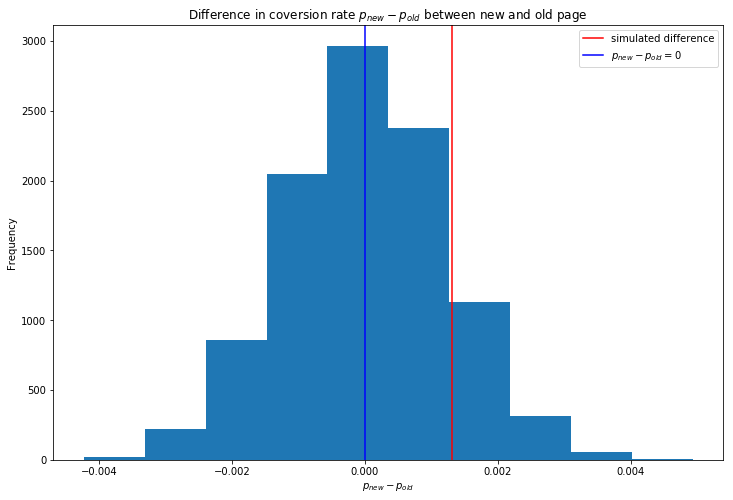

In [30]:
plt.figure(figsize=(12,8))
plt.hist(p_diffs);
plt.title("Difference in coversion rate $p_{new} - p_{old}$ between new and old page");
plt.xlabel("$p_{new} - p_{old}$");
plt.ylabel("Frequency");

diff = sim_diff - p_diffs.mean()
plt.axvline(diff, c="r", label="simulated difference");
plt.axvline(0, c="b", label="$p_{new} - p_{old} = 0$");
plt.legend();

What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
actual_diff = df2.query("group == 'treatment'").converted.mean() - df2.query("group == 'control'").converted.mean()
p_val = (p_diffs > actual_diff).mean()
p_val

0.9061

The value calculated in part above is called the p-value. This means if the null hypothesis is true, the p-value is the probability of obtaining the observed statistic or one more extreme in favour of the alternative. 

Since the p-value is very large (0.9061), and much larger than the conventional threshold of $\alpha = 0.05$, the observed difference is likely to come from the null. Thus, we have insufficient evidence to reject the null hypothesis. Therefore, we conclude that the conversion rates of the old page is the same or better than the new page.

#### Using statsmodels built-in function

Using statsmodels built-in function, similar results as above can to achieved.

In [33]:
import statsmodels.api as sm

In [34]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Calculate the number of conversions for each page, as well as the number of individuals who received each page. 

In [35]:
convert_old = df2.query("landing_page == 'old_page'").converted.mean()
convert_new = df2.query("landing_page == 'new_page'").converted.mean()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]
print("Conversion rate old page:", convert_old)
print("Conversion rate new page:", convert_new)
print("Number of individuals receiving old page:", n_old)
print("Number of individuals receiving new page:", n_new)

Conversion rate old page: 0.1203863045004612
Conversion rate new page: 0.11880806551510564
Number of individuals receiving old page: 145274
Number of individuals receiving new page: 145310


Using `stats.proportions_ztest`, the test statistic and p-value can be computed.  [This](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built-in function.

In [37]:
# statsmodels.stats.proportion.proportions_ztest(count, nobs, value=None, alternative='two-sided', prop_var=False)
# parameters: "count" is the number of successful trials, i.e. the number of Yes events in your list.
# "nobs" is the total number of trials, i.e. the number of rows in your list.

# returns zstat: test statistic for the z-test, and p-value: p-value for the z-test

success_new = convert_new * n_new
success_old = convert_old * n_old

z_s, p_v = sm.stats.proportions_ztest([success_new, success_old], [n_new, n_old], alternative='larger')
z_s, p_v

(-1.3109241984234394, 0.9050583127590245)

The z-score indicates how many standard deviations the actual difference is from the mean. In this case, the z-score is negative which indicate that the difference in conversion rates between new and old page is less than zero, i.e. the new page has a lower conversion rate than the old page. 

The p-value as described above is the probability of obtaining the observed statistic or one more extreme in favour of the alternative. The p-value is slightly different (sampling: p_val = 0.9061, vs. above: p_val = 0.9051), but the difference is small. Thus, the findings of the p-values agree well with each other.

<a id='regression'></a>
### Part III - A regression approach

The previous A/B test can also be achieved by performing regression. Since each row is either a conversion or no conversion (categorical), logistic regression will be used to predict the categorical response.

Below, we will look at if individually the page received and the country of residence by the user affect the conversion rate. Then, we will look if both page received and country affect the conversion rate.

#### 1. Does the page received by the user affect the conversion rate?

First, create a column for the intercept, and create a dummy variable column (required for categorical variable) for which page each user received. An **intercept** column and an **ab_page** column is added, where 1 is when an individual receives the **treatment** and 0 if **control**.

In [38]:
# Add intercept, create dummy columns for new_page and old_page
# Create ab_page where value=1 for treatment, and value=0 for control group
df3 = df2.copy()
df3["intercept"] = 1
df3[["new_page", "old_page"]] = pd.get_dummies(df2.landing_page)
df3[["dummy_page", "ab_page"]] = pd.get_dummies(df2.group) 
df3.drop("dummy_page", axis = 1, inplace=True)
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


Now, **statsmodels** will be used to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives from `ab_page` column.

In [39]:
# Baseline: ab_page, i.e. whether the user received the "treatment" group (new_page) or not
logit_mod = sm.Logit(df3["converted"], df3[["intercept", "ab_page"]])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 03 Sep 2019   Pseudo R-squ.:               8.077e-06
Time:                        17:12:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The null and alternative hypothesis in a regression model for `ab_page` is:

$H_0:$ `ab_page` is not significant, i.e. coefficient = 0<br>
$H_1:$ `ab_page` is significant, i.e. coefficient $\neq$ 0

Thus, for low p-values, we would have evidence to suggest that the explanatory variable is statistically significant in helping predict the response variable. In this case, the p-value associated with `ab_page` is 0.190. This suggest that the `treatment` group is **not statistically significant** in predicting whether a user will convert or not as it is above the threshold value of $\alpha = 0.05$.

Note that the p-value in regression (p-value = 0.190) differ from Part II (p-value = 0.9061) since the null and alternative hypothesis for both parts are very different. The null and alternative hypothesis in Part II compares the difference in the numeric conversion rates between old and new page.

#### 2. Does the country of residence affect the conversion rate?

It is a good idea to consider all possible explanatory factors in the regression model that may have influence the response variable. This would allow for a more accurate prediction for the response. 

However, potential disadvantages of adding additional explantory factors include non-linearity between explanatory and response variables, correlation of error terms (when data is collected over time), non-constant variance, outliers, and multicollinearity (predictor variables that are correlated with one another).

Along with testing if the conversion rate changes for different pages, does the conversion rate change based on which country a user lives? Additional data from the dataset is stored in the `countries.csv` dataset.

In [41]:
# First join the countries DF together with the conversion DF
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted
user_id,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0


In [43]:
# Countries of different users
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

Countries are categorical variables, so we need to create dummy columns for these variables. Since there are three countries (US, UK, and Canada), we will only use two columns in the regression model. It is vital to ensure to have linearly independent columns by dropping one of the columns (also called the baseline) and therefore a matrix of full rank. All the coefficients are then compared with the baseline.

In [44]:
### Create the necessary dummy variables for "country"
df_new[["country_CA", "country_UK", "country_US"]] = pd.get_dummies(df_new.country)
df_new.iloc[30:40]

,country,timestamp,group,landing_page,converted,country_CA,country_UK,country_US
user_id,,,,,,,,
666209,US,2017-01-15 09:07:44.165334,treatment,new_page,0,0,0,1
652847,US,2017-01-10 15:53:59.340311,control,old_page,1,0,0,1
921903,US,2017-01-20 00:32:41.892599,control,old_page,0,0,0,1
908277,US,2017-01-14 18:21:11.541573,control,old_page,0,0,0,1
641084,US,2017-01-14 22:32:11.049753,control,old_page,0,0,0,1
739948,UK,2017-01-12 10:40:33.349696,treatment,new_page,0,0,1,0
907395,US,2017-01-20 13:46:26.770614,control,old_page,0,0,0,1
709491,US,2017-01-15 12:42:40.374460,treatment,new_page,0,0,0,1
790145,US,2017-01-17 19:09:51.178807,treatment,new_page,0,0,0,1


In [45]:
# Find whether the country affects the conversion rate. 
# Baseline: country_CA
df_new["intercept"] = 1

# Only use two columns
logit_mod2 = sm.Logit(df_new["converted"], df_new[["intercept", "country_UK", "country_US"]])
results2 = logit_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 03 Sep 2019   Pseudo R-squ.:               1.521e-05
Time:                        17:24:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
country_UK     0.0507      0.028      1.786      0.074      -0.005       0.106
country_US     0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

As shown above, the p-values for all three countries are above the threshold $\alpha = 0.05$. Thus, we have insufficient evidence to suggest that the countries do have an impact on conversions.

So far, we looked at whether the individual factors of country and page affect conversion rate. Now, we would like to look at an interaction between page and country to see if there significant effects on conversion.

#### 3. Do page received and country of residence affect conversion rate?

New columns need to be created to add interaction terms for `ab_CA`, `ab_UK`, and `ab_US`. For example, `ab_CA` is obtained by the product of `ab_page` and `country_CA`. Recall that `ab_page` equal to 1 refers to treatment group whereas equal to zero if they are from the control group. 

In [46]:
### Fit Your Linear Model And Obtain the Results
# ab_page is 1 when the group is "treatment" (or new_page), and 0 when it is "control" (or old_page)
df_new[["dummy_page", "ab_page"]] = pd.get_dummies(df_new.group) 
df_new.drop("dummy_page", axis = 1, inplace=True)
df_new.head()

,country,timestamp,group,landing_page,converted,country_CA,country_UK,country_US,intercept,ab_page
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,1,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0,1,1


In [47]:
# Add interaction term for ab_CA, ab_UK, and ab_US
df_new["ab_CA"] = df_new.country_CA * df_new.ab_page
df_new["ab_UK"] = df_new.country_UK * df_new.ab_page
df_new["ab_US"] = df_new.country_US * df_new.ab_page
df_new.head()

,country,timestamp,group,landing_page,converted,country_CA,country_UK,country_US,intercept,ab_page,ab_CA,ab_UK,ab_US
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,1,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0,1,1,0,1,0


In [48]:
# Fit model using interaction term (and its lower order terms)
# Baseline variables are country_CA and ab_CA
logit_mod3 = sm.Logit(df_new["converted"], 
                      df_new[["intercept", "ab_page", "country_CA", "country_UK", "ab_CA", "ab_UK"]])
results3 = logit_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 03 Sep 2019   Pseudo R-squ.:               3.482e-05
Time:                        17:34:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
country_CA    -0.0175      0.038     -0.465      0.642      -0.091       0.056
country_UK    -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_CA         -0.0469      0.054     -0.872      0.383      -0.152       0.059
ab_UK          0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

When taking different baseline values to fit the model, all interaction terms and its lower order terms have a p-value above the threshold ($\alpha =  0.05$). This suggests all the interaction terms are statistically insignificant in predicting conversion rates. Whether a user receives an old or new page, or where they are from, there is insufficient evidence to suggest that `new_page` is better or worse than the `old_page`.

<a id='conclusions'></a>
## Conclusions

To conclude, it is recommended to keep the `old_page`. 

Statistically, the results in both Part II (A/B Testing) and Part III (Regression) suggest that there is insufficient evidence to suggest that the `new_page` is better than the `old_page`. In addition, the country of residence of the user does not provide statistically significant evidence on whether a user will convert.    

Practically, keeping the `old_page` would save the company money and time instead of implementing the `new_page`, since there is no difference between the two pages. In addition, it would avoid potential disadvantages from implementing a new page, such as due to change aversion. 

Additional analysis would involve running it for longer and see the effects of time on conversion rates.